# Classification model for suicide data
In this notebook I will try to use a classification model that computes a score for a given person, with given data, to be in risk to try to suicide.

# Common functions (RUN ME FIRST)


In [129]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import OneHotEncoder
#from sklearn.preprocessing import LabelEncoder
from pyod.models.iforest import IForest
from pyod.models.ocsvm import OCSVM
from pyod.models.pca import PCA
from pyod.models.suod import SUOD
from pyod.models.xgbod import XGBOD
from pyod.models.feature_bagging import FeatureBagging
#import pickle
import joblib 
import plotly.express as px
import brminer
from sklearn.metrics import roc_auc_score
from scipy.special import erf


###############
def preprocess_data(datafile, var_name, model_name, expand_rows, test_size, contamination, nsamples):
    print(f"Reading data from file: {datafile} ...")
    
    #df = pd.read_csv(datafile).reset_index(drop=True)    
    df = pd.DataFrame({'A' : []})
    if nsamples == -1:
        df = pd.read_csv(datafile).reset_index(drop=True)
    else: 
        df = pd.read_csv(datafile).sample(n=nsamples, random_state=1).reset_index(drop=True)

    print(f"  Keeping only columns: MUNICIPIO, DPTO, GENDER, {var_name}")
    print(f"  Year is not useful sinde the end user does not use it")
    df.drop(columns=["YEAR", "LONGITUD", "LATITUD", "CODE_MUNICIPIO", "CODE_DPTO"], inplace=True)
    #display(df.head())
    dftrain = df
    dffull = pd.read_csv(datafile).reset_index(drop=True)
    
    # One hot encoding 
    ###############
    print(f"Enconding data (using one-hot encoding) ...")
    #print(dftrain.dtypes)
    CAT_LIST = [var_name, "GENDER", "DPTO", "MUNICIPIO"]
    # Set categories
    for field in CAT_LIST:
        dftrain[field] = dftrain[field].astype("category")
        dffull[field] = dffull[field].astype("category")
    # One-hot encoding: Creatings many new columns, but does not assing artificial weights
    dftrain = pd.get_dummies(dftrain, columns=CAT_LIST)
    print(f"{dftrain.shape=}")
    dffull = pd.get_dummies(dffull, columns=CAT_LIST)
    print(f"{dffull.shape=}")

    print(f"  Saving testing dataframe with SUI_COUNTER==0 ...")
    dftrain[dftrain["SUI_COUNTER"]== 0].drop(["SUI_COUNTER"], axis=1).head(1000).to_csv(f"OUTPUT/{var_name}_{model_name}_test_SUICOUNTER_eq_0.csv.zip", index = False)
    print("  Saving test dataframe with SUI_COUNTER>=30 ...")
    dftrain[dftrain["SUI_COUNTER"]>=30].drop(["SUI_COUNTER"], axis=1).to_csv(f"OUTPUT/{var_name}_{model_name}_test_SUICOUNTER_ge_30.csv.zip", index = False)
    #dffull[dffull["SUI_COUNTER"]>=30].drop(["SUI_COUNTER"], axis=1).to_csv(f"OUTPUT/{var_name}_{model_name}_test_SUICOUNTER_ge_30.csv.zip", index = False)
    print("  Saving test dataframe with SUI_COUNTER>=2 ...")
    dftrain[dftrain["SUI_COUNTER"]>=2].drop(["SUI_COUNTER"], axis=1).to_csv(f"OUTPUT/{var_name}_{model_name}_test_SUICOUNTER_ge_2.csv.zip", index = False)
    print("  Saving test dataframe with SUI_COUNTER==2 ...")
    dftrain[dftrain["SUI_COUNTER"]==2].drop(["SUI_COUNTER"], axis=1).to_csv(f"OUTPUT/{var_name}_{model_name}_test_SUICOUNTER_eq_2.csv.zip", index = False)
    
    print(f"Saving template dataframe for frontend consulting ...")
    dftemp = dftrain[dftrain["SUI_COUNTER"]>=1].sample(n=1, random_state=1).drop(["SUI_COUNTER"], axis=1).reset_index(drop=True)
    dftemp.iloc[0, :] = 0
    #display(dftemp)
    dftemp.to_csv(f"OUTPUT/{var_name}_{model_name}_TEMPLATE.csv", index=False)
    
    #print(f"Reducing the data to a subsample of size: {nsamples} ...")
    #if nsamples >= 1: 
    #    dftrain = dftrain.sample(n=nsamples, random_state=1).reset_index(drop=True)

    
    ###############
    # To introduce the weight in SUI_COUNTER, each row with SUI_COUNTER >= 2 will be replaced
    # by SOI_COUNTER rows with SUI_COUNTER=1
    if expand_rows == True:
        print("Replacing rows with SUI_COUNTER = N >= 2 with N rows with SUI_COUNTER = 1 ...")
        print(f"  Initial shape for train dataframe: {dftrain.shape}")
        indexes = dftrain[dftrain["SUI_COUNTER"]>=2].index
        df_newrows = dftrain.iloc[:0, :].copy()
        for idx in indexes:
            row = dftrain.iloc[idx, :].copy()
            sui_counter = row["SUI_COUNTER"]
            row["SUI_COUNTER"] = 1
            #df_newrows = df_newrows.append([row]*sui_counter, ignore_index=True) # append is deprecated
            df_newrows = pd.concat([df_newrows, pd.DataFrame([row]*sui_counter)], ignore_index=True)
        print("  Appending the new multiplied rows ...")
        dftrain = pd.concat([dftrain, df_newrows], ignore_index=True)
        print(f"  Final shape for train dataframe: {dftrain.shape}")
        print(f"  Number of cases == 0: ", dftrain[dftrain["SUI_COUNTER"]==0].shape)
        print(f"  Number of cases == 1: ", dftrain[dftrain["SUI_COUNTER"]==1].shape)
        print(f"  Removing rows with SUI_COUNTER >= 2 since rows where expanded ...")
        dftrain = dftrain[dftrain["SUI_COUNTER"] <= 1]   
    print(f"{dftrain.shape=}")

    ###############
    print(f"Splitting data into training and test ...")
    X = dftrain.drop(['SUI_COUNTER'], axis=1)
    y = dftrain.loc[:, ['SUI_COUNTER']] 
    print(f"{X.shape=}")
    print(f"{y.shape=}")
    if expand_rows == True and model_name != 'brm':
        print(f"  For training, start with only SUI_COUNTER==1 (removing 0 or >= 2) ...") 
        X = dftrain[dftrain["SUI_COUNTER"]==1].drop(["SUI_COUNTER"], axis=1)
        y = dftrain.loc[dftrain["SUI_COUNTER"]==1, ['SUI_COUNTER']] 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = 20)
    print(f"{X_train.shape=}")
    print(f"{X_test.shape=}")
    print(f"{y_train.shape=}")
    print(f"{y_test.shape=}")
    print(f"  Saving testing dataframes from split ...")    
    X_test.to_csv(f"OUTPUT/{var_name}_Xtest-{model_name}.csv.zip", index = False)
    y_test.to_csv(f"OUTPUT/{var_name}_ytest-{model_name}.csv.zip", index = False)

    if contamination > 0.0:
        print(f"  Now adding a {contamination*100}% contamination with SUI_COUNTER==0 ...")
        nrows_to_add = int(X_train.shape[0]*contamination)
        print(f"    rows to add: {nrows_to_add}")
        print(f"    rows available from SUI_COUNTER==0: ", dftrain[dftrain["SUI_COUNTER"]==0].shape)
        assert(nrows_to_add <= dftrain[dftrain["SUI_COUNTER"]==0].shape[0])
        print(f"    Adding the random sample from SUI_COUNTER==0")
        X_train = pd.concat([X_train, dftrain[dftrain["SUI_COUNTER"]==0].drop(["SUI_COUNTER"], axis=1).sample(n=nrows_to_add, random_state=1)], ignore_index=True)    
        print(f"    New train shape after adding {contamination*100}% with SUI_COUNTER==0: {X_train.shape=}")
        # TODO y_train
    
    print("Done")
    
    return X_train, X_test, y_train, y_test
    
def train_model(X_train, var_name, model_name, contamination, y_train=None):
    print(f"Applying classification with {model_name} ...")
    # Use this as default
    clf = IForest()
    if model_name == "iforest":
        print(f"  https://pyod.readthedocs.io/en/latest/pyod.models.html#module-pyod.models.iforest")
        clf.fit(X_train.to_numpy())
    elif model_name == "suod":
        detector_list = [#IForest(n_estimators=100, contamination=contamination, n_jobs=2), 
                         #IForest(n_estimators=200, contamination=contamination, n_jobs=2), 
                         PCA(contamination=contamination),
                         OCSVM(contamination=contamination)
                        ]
        clf = SUOD(base_estimators=detector_list, n_jobs=-1, combination='average', verbose=True)
        clf.fit(X_train.to_numpy())
    elif model_name == "feature_bagging":
        clf = FeatureBagging(n_estimators=10, contamination=contamination, max_features=1.0, 
                             bootstrap_features=False, check_detector=True, check_estimator=False, 
                             n_jobs=-1, random_state=20, combination='average', verbose=True, 
                             estimator_params=None)
        clf.fit(X_train.to_numpy())
    elif model_name == "brm" :
        clf = brminer.BRM(user_threshold=95, classifier_count=10)
        clf.fit(X_train, y_train)
    elif model_name == "xgbod":
        clf = XGBOD(max_depth=3, learning_rate=0.1, n_estimators=2, silent=False, objective='binary:logistic', 
                    booster='gbtree', n_jobs=-1, gamma=0, min_child_weight=1, max_delta_step=0, 
                    subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
                    scale_pos_weight=1, base_score=0.5, random_state=0)
        clf.fit(X_train, y_train.to_numpy().ravel())
    
    ###############
    fname=f"OUTPUT/{var_name}-{model_name}.joblib"
    print(f"Saving the model to: {fname} ")
    with open(f"{fname}", 'wb') as f:
        joblib.dump(clf, f, compress=9)

    print("Done.")
    
def load_model(fname):
    print(f"Loading model from: {fname} ...")
    with open(fname, 'rb') as f:
        return joblib.load(f)

def compute_probs(model, data, model_name):
    ###############
    print("Computing inliers probabilities ...")
    prob = np.array([])
    if model_name == "iforest":
        prob = model.predict_proba(data.to_numpy(), method='linear', return_confidence=False)[:,0]
    elif model_name == "suod":
        prob = model.predict_proba(data.to_numpy())
    elif model_name in ["feature_bagging"]:
        prob = model.predict_proba(data.to_numpy(), method='linear', return_confidence=False)[:,1]  
        #print(model.predict_proba(data.to_numpy(), method='linear', return_confidence=False))
        #print(prob)
    elif model_name == "xgbod":
        prob = model.predict_proba(data.to_numpy())
    elif model_name == "brm":
        decision_scores = np.array(model.score_samples(data))
        threshold = 0.98
        decision_scores[decision_scores>=threshold] = 1.8
        #l = decision_scores[decision_scores<threshold].shape[0]
        #decision_scores[decision_scores<threshold] = np.random.uniform(0.0001, 0.001, size=(l))
        prob = compute_probs_from_scores(decision_scores)
    return prob


def test_probs(var_name, model_name):
    print(f"Using {var_name:}")
    print(f"Using {model_name:}")
    model = load_model(f"OUTPUT/{var_name}-{model_name}.joblib")
    flag = True
    for ii, suffix in enumerate(["test_SUICOUNTER_ge_30.csv.zip", "test_SUICOUNTER_eq_0.csv.zip"]): 
        print(f"  Test with data: {suffix} ...")
        bname = suffix.replace("test_SUICOUNTER_", "").replace(".zip", "")
        test_data = pd.read_csv(f"OUTPUT/{var_name}_{model_name}_{suffix}")
        if(test_data.shape[0] < 1): 
            flag = False
            break
        probs = compute_probs(model, test_data, model_name)
        vals, edges = np.histogram(probs, bins=20, range=(0.0, 1.0), density=False)
        vals = 1.0*vals
        vals /= vals.max()
        if ii==0:
            fig = px.bar(x=edges[:-1], y=vals, title=f"TESTING: {var_name}", color=px.Constant(f"{bname}"), 
                         labels=dict(x="Prob", y="count/max", color=f"Test case"), opacity=0.95,barmode='group',
                        width=600, height=400) #overlay
        else:
            fig.add_bar(x=edges[:-1], y=vals, name=f"{bname}", opacity=0.95)            
    if flag: 
        fig.show()


def compute_prob(dpto, municipio, gender, var_name, var_value, model, model_name, verbose=False):
    """
    This function is called from the data selected in the frontend and returns the 
    probability associated. 
    Usage examples:
    VAR_NAME="CAUSE"
    MODEL_NAME="brm"
    model = load_model(f"OUTPUT/{VAR_NAME}-{MODEL_NAME}.joblib")
    print(compute_prob("BOGOTA", "BOGOTA", "MASCULINO", VAR_NAME, "Desamor", model, MODEL_NAME))
    print(compute_prob("ANTIOQUIA", "MEDELLIN", "MASCULINO", VAR_NAME, "Bullying", model, MODEL_NAME))
    print(compute_prob("CAUCA", "SUAREZ", "MASCULINO", VAR_NAME, "Acceso a armas de fuego", model, MODEL_NAME))
    """
    # load template dataframe with right colnames and zero values
    df = pd.read_csv(f"OUTPUT/{var_name}_{model_name}_TEMPLATE.csv").head(1)
    # Setup 1 on dpto municipio gender var_name var_value
    df.loc[0, [f"DPTO_{dpto}", f"MUNICIPIO_{municipio}", f"GENDER_{gender}", f"{var_name}_{var_value}"]] = 1
    # if verbose: 
    #     display(df)
    # compute the probability
    prob = -1.0
    if model_name == "brm":
        decision_scores = np.array(model.score_samples(df))
        if verbose:
            print(f"{decision_scores=}")
        threshold = 0.98
        decision_scores[decision_scores>=threshold] = 1.8
        prob = compute_probs_from_scores(decision_scores)
        if verbose:
            print(f"{prob=}")
    return prob[0]


def compute_probs_from_scores(scores):
    if len(scores) == 1:
        XMIN=np.sqrt(2)/2
        XMAX=1.0
        probs = ((scores-XMIN)/(XMAX-XMIN)).clip(0, 1.0).ravel()
        return probs
    pre_erf_scores = scores
    std = np.std(scores)
    if len(scores) >= 2 and std > 0.0:
        pre_erf_scores = ( scores - np.mean(scores) ) / ( np.std(scores) * np.sqrt(2) )
    else :
        pre_erf_scores /= np.sqrt(2)
    erf_score = erf(pre_erf_scores)
    probs = erf_score.clip(0, 1.0).ravel()
    return probs


# Isolation forest
This was suggested by our TA Leonardo and is a fast method to detect outliers. I will try to implement it with very simple data and then improve it if possible.
Some Refs:
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html
- https://stackoverflow.com/questions/54886223/isolation-forest-categorical-data
- https://www.analyticsvidhya.com/blog/2021/07/anomaly-detection-using-isolation-forest-a-complete-guide/
- https://towardsdatascience.com/how-to-perform-anomaly-detection-with-the-isolation-forest-algorithm-e8c8372520bc
- https://www.frontiersin.org/articles/10.3389/fpsyt.2017.00192/full
- https://www.nature.com/articles/s41746-020-0287-6
- https://arxiv.org/pdf/2201.10515.pdf
- https://stackoverflow.com/questions/67357849/conversion-of-isolationforest-decision-score-to-probability-algorithm

NOTE: It is still not clear for me how the data should be organized. For now I will try to just 

## Training 
In this part I will put the functions associated with the training, serialization and so on

In [127]:
CONTAMINATION=0.10
MODEL_NAME="iforest"
for var_name in ["CAUSE", "SCHOLARSHIP", "AGE_GROUP", "MARITAL_STATUS", "VULNERABILITY_FACTOR"]:
#for var_name in ["CAUSE"]:
#for var_name in ["VULNERABILITY_FACTOR"]:
    print(f"\nTraining with data: {var_name}")
    X_train, _, _, _ = preprocess_data(f"INPUTDATA/NEWCSV/MERGED-2016-2022-Suicidios-Geo-{var_name}.csv", var_name, 
                                        MODEL_NAME, expand_rows = True, test_size = 0.001, contamination=CONTAMINATION,
                                        nsamples=8000)
    train_model(X_train, var_name, MODEL_NAME, contamination=CONTAMINATION)


Training with data: CAUSE
Reading data from file: INPUTDATA/NEWCSV/MERGED-2016-2022-Suicidios-Geo-CAUSE.csv ...
  Keeping only columns: MUNICIPIO, DPTO, GENDER, CAUSE
  Year is not useful sinde the end user does not use it
Enconding data (using one-hot encoding) ...
dftrain.shape=(8000, 898)
dffull.shape=(115988, 910)
  Saving testing dataframe with SUI_COUNTER==0 ...
  Saving test dataframe with SUI_COUNTER>=30 ...
  Saving test dataframe with SUI_COUNTER>=2 ...
  Saving test dataframe with SUI_COUNTER==2 ...
Saving template dataframe for frontend consulting ...
Replacing rows with SUI_COUNTER = N >= 2 with N rows with SUI_COUNTER = 1 ...
  Initial shape for train dataframe: (8000, 898)
  Appending the new multiplied rows ...
  Final shape for train dataframe: (8634, 898)
  Number of cases == 0:  (7556, 898)
  Number of cases == 1:  (949, 898)
  Removing rows with SUI_COUNTER >= 2 since rows where expanded ...
dftrain.shape=(8505, 898)
Splitting data into training and test ...
X.shap

## Testing

Using CAUSE
Using iforest
Loading model from: OUTPUT/CAUSE-iforest.joblib ...
  Test with data: test_SUICOUNTER_ge_30.csv.zip ...
Computing inliers probabilities ...
  Test with data: test_SUICOUNTER_eq_0.csv.zip ...
Computing inliers probabilities ...


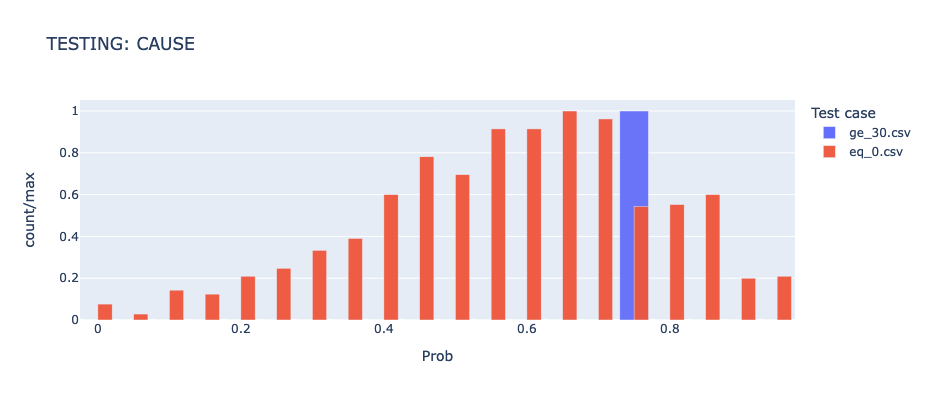

Using SCHOLARSHIP
Using iforest
Loading model from: OUTPUT/SCHOLARSHIP-iforest.joblib ...
  Test with data: test_SUICOUNTER_ge_30.csv.zip ...
Computing inliers probabilities ...
  Test with data: test_SUICOUNTER_eq_0.csv.zip ...
Computing inliers probabilities ...


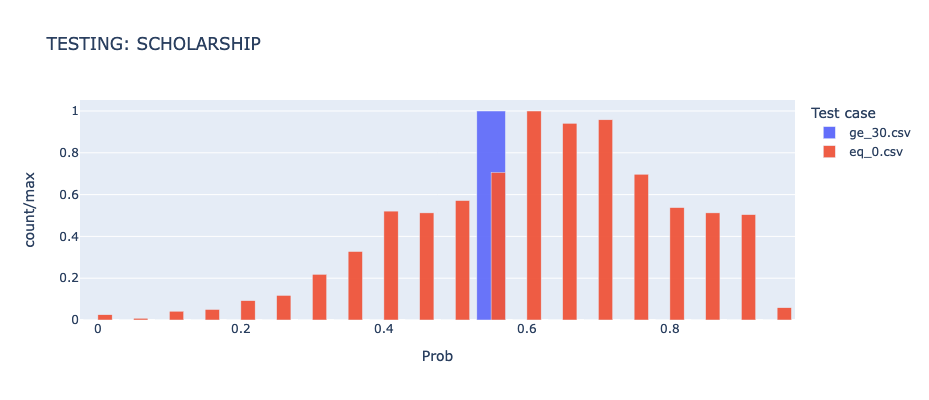

Using AGE_GROUP
Using iforest
Loading model from: OUTPUT/AGE_GROUP-iforest.joblib ...
  Test with data: test_SUICOUNTER_ge_30.csv.zip ...
Computing inliers probabilities ...
  Test with data: test_SUICOUNTER_eq_0.csv.zip ...
Computing inliers probabilities ...


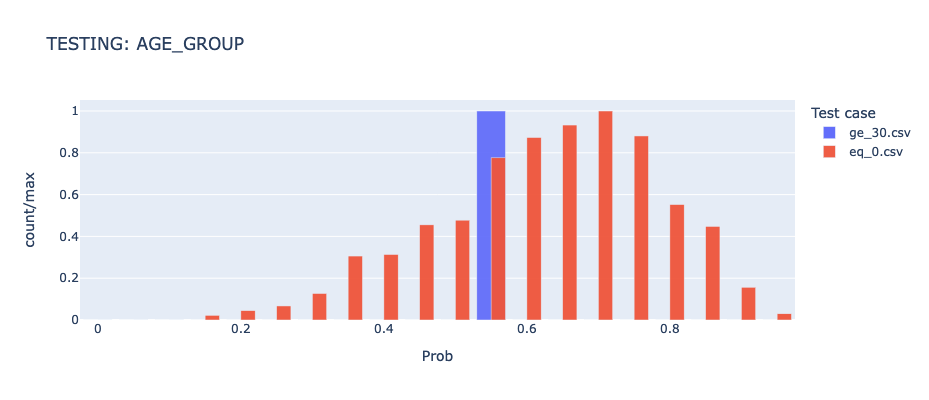

Using MARITAL_STATUS
Using iforest
Loading model from: OUTPUT/MARITAL_STATUS-iforest.joblib ...
  Test with data: test_SUICOUNTER_ge_30.csv.zip ...
Computing inliers probabilities ...
  Test with data: test_SUICOUNTER_eq_0.csv.zip ...
Computing inliers probabilities ...


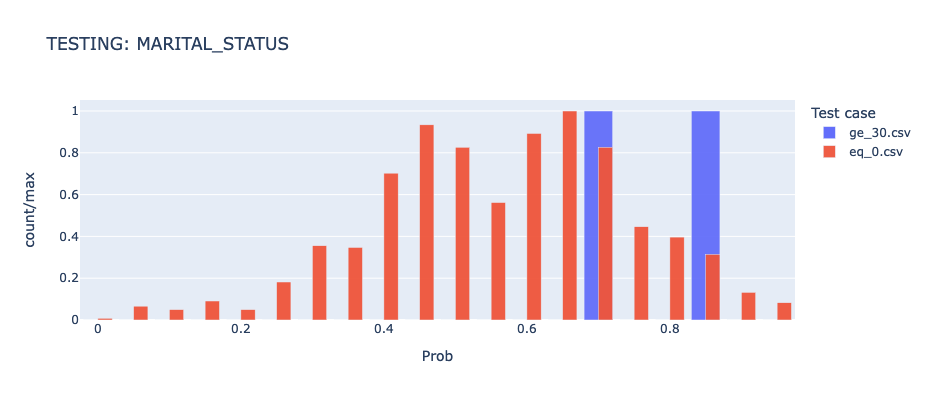

Using VULNERABILITY_FACTOR
Using iforest
Loading model from: OUTPUT/VULNERABILITY_FACTOR-iforest.joblib ...
  Test with data: test_SUICOUNTER_ge_30.csv.zip ...


In [130]:
MODEL_NAME="iforest"
for VAR_NAME in ["CAUSE", "SCHOLARSHIP", "AGE_GROUP", "MARITAL_STATUS", "VULNERABILITY_FACTOR"]:
#for VAR_NAME in ["CAUSE"]:
    test_probs(VAR_NAME, MODEL_NAME)

# Combining several estimators with SUOD from pyod
## Training

In [136]:
CONTAMINATION=0.05
MODEL_NAME="suod"
for var_name in ["CAUSE", "SCHOLARSHIP", "AGE_GROUP", "MARITAL_STATUS", "VULNERABILITY_FACTOR"]:
#for var_name in ["CAUSE"]:
    print(f"\nTraining with data: {var_name}")
    X_train, _, _, _ = preprocess_data(f"INPUTDATA/NEWCSV/MERGED-2016-2022-Suicidios-Geo-{var_name}.csv", var_name, 
                                      MODEL_NAME, expand_rows = True, test_size = 0.001, contamination=CONTAMINATION, 
                                      nsamples=10000)
    train_model(X_train, var_name, MODEL_NAME, contamination=CONTAMINATION)


Training with data: CAUSE
Reading data from file: INPUTDATA/NEWCSV/MERGED-2016-2022-Suicidios-Geo-CAUSE.csv ...
  Keeping only columns: MUNICIPIO, DPTO, GENDER, CAUSE
  Year is not useful sinde the end user does not use it
Enconding data (using one-hot encoding) ...
dftrain.shape=(10000, 903)
dffull.shape=(115988, 910)
  Saving testing dataframe with SUI_COUNTER==0 ...
  Saving test dataframe with SUI_COUNTER>=30 ...
  Saving test dataframe with SUI_COUNTER>=2 ...
  Saving test dataframe with SUI_COUNTER==2 ...
Saving template dataframe for frontend consulting ...
Replacing rows with SUI_COUNTER = N >= 2 with N rows with SUI_COUNTER = 1 ...
  Initial shape for train dataframe: (10000, 903)
  Appending the new multiplied rows ...
  Final shape for train dataframe: (10701, 903)
  Number of cases == 0:  (9461, 903)
  Number of cases == 1:  (1087, 903)
  Removing rows with SUI_COUNTER >= 2 since rows where expanded ...
dftrain.shape=(10548, 903)
Splitting data into training and test ...
X

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Balanced Scheduling Total Train Time: 2.700090169906616
Split among workers default: [1 2] [1]


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    2.7s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.8s finished


Saving the model to: OUTPUT/CAUSE-suod.joblib 
Done.

Training with data: SCHOLARSHIP
Reading data from file: INPUTDATA/NEWCSV/MERGED-2016-2022-Suicidios-Geo-SCHOLARSHIP.csv ...
  Keeping only columns: MUNICIPIO, DPTO, GENDER, SCHOLARSHIP
  Year is not useful sinde the end user does not use it
Enconding data (using one-hot encoding) ...
dftrain.shape=(10000, 895)
dffull.shape=(121834, 903)
  Saving testing dataframe with SUI_COUNTER==0 ...
  Saving test dataframe with SUI_COUNTER>=30 ...
  Saving test dataframe with SUI_COUNTER>=2 ...
  Saving test dataframe with SUI_COUNTER==2 ...
Saving template dataframe for frontend consulting ...
Replacing rows with SUI_COUNTER = N >= 2 with N rows with SUI_COUNTER = 1 ...
  Initial shape for train dataframe: (10000, 895)
  Appending the new multiplied rows ...
  Final shape for train dataframe: (10668, 895)
  Number of cases == 0:  (9429, 895)
  Number of cases == 1:  (1083, 895)
  Removing rows with SUI_COUNTER >= 2 since rows where expanded ...

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Balanced Scheduling Total Train Time: 2.726660966873169
Split among workers default: [1 2] [1]


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    2.6s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.0s finished


Saving the model to: OUTPUT/SCHOLARSHIP-suod.joblib 
Done.

Training with data: AGE_GROUP
Reading data from file: INPUTDATA/NEWCSV/MERGED-2016-2022-Suicidios-Geo-AGE_GROUP.csv ...
  Keeping only columns: MUNICIPIO, DPTO, GENDER, AGE_GROUP
  Year is not useful sinde the end user does not use it
Enconding data (using one-hot encoding) ...
dftrain.shape=(10000, 897)
dffull.shape=(135398, 909)
  Saving testing dataframe with SUI_COUNTER==0 ...
  Saving test dataframe with SUI_COUNTER>=30 ...
  Saving test dataframe with SUI_COUNTER>=2 ...
  Saving test dataframe with SUI_COUNTER==2 ...
Saving template dataframe for frontend consulting ...
Replacing rows with SUI_COUNTER = N >= 2 with N rows with SUI_COUNTER = 1 ...
  Initial shape for train dataframe: (10000, 897)
  Appending the new multiplied rows ...
  Final shape for train dataframe: (10465, 897)
  Number of cases == 0:  (9388, 897)
  Number of cases == 1:  (956, 897)
  Removing rows with SUI_COUNTER >= 2 since rows where expanded ...


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Balanced Scheduling Total Train Time: 2.348956823348999
Split among workers default: [1 2] [1]


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    2.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.9s finished


Saving the model to: OUTPUT/AGE_GROUP-suod.joblib 
Done.

Training with data: MARITAL_STATUS
Reading data from file: INPUTDATA/NEWCSV/MERGED-2016-2022-Suicidios-Geo-MARITAL_STATUS.csv ...
  Keeping only columns: MUNICIPIO, DPTO, GENDER, MARITAL_STATUS
  Year is not useful sinde the end user does not use it
Enconding data (using one-hot encoding) ...
dftrain.shape=(10000, 889)
dffull.shape=(89334, 899)
  Saving testing dataframe with SUI_COUNTER==0 ...
  Saving test dataframe with SUI_COUNTER>=30 ...
  Saving test dataframe with SUI_COUNTER>=2 ...
  Saving test dataframe with SUI_COUNTER==2 ...
Saving template dataframe for frontend consulting ...
Replacing rows with SUI_COUNTER = N >= 2 with N rows with SUI_COUNTER = 1 ...
  Initial shape for train dataframe: (10000, 889)
  Appending the new multiplied rows ...
  Final shape for train dataframe: (11171, 889)
  Number of cases == 0:  (9264, 889)
  Number of cases == 1:  (1708, 889)
  Removing rows with SUI_COUNTER >= 2 since rows where 

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Balanced Scheduling Total Train Time: 4.6156721115112305
Split among workers default: [1 2] [1]


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    4.5s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    4.5s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.1s finished


Saving the model to: OUTPUT/MARITAL_STATUS-suod.joblib 
Done.

Training with data: VULNERABILITY_FACTOR
Reading data from file: INPUTDATA/NEWCSV/MERGED-2016-2022-Suicidios-Geo-VULNERABILITY_FACTOR.csv ...
  Keeping only columns: MUNICIPIO, DPTO, GENDER, VULNERABILITY_FACTOR
  Year is not useful sinde the end user does not use it
Enconding data (using one-hot encoding) ...
dftrain.shape=(10000, 912)
dffull.shape=(241308, 923)
  Saving testing dataframe with SUI_COUNTER==0 ...
  Saving test dataframe with SUI_COUNTER>=30 ...
  Saving test dataframe with SUI_COUNTER>=2 ...
  Saving test dataframe with SUI_COUNTER==2 ...
Saving template dataframe for frontend consulting ...
Replacing rows with SUI_COUNTER = N >= 2 with N rows with SUI_COUNTER = 1 ...
  Initial shape for train dataframe: (10000, 912)
  Appending the new multiplied rows ...
  Final shape for train dataframe: (10240, 912)
  Number of cases == 0:  (9771, 912)
  Number of cases == 1:  (409, 912)
  Removing rows with SUI_COUNTER

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Balanced Scheduling Total Train Time: 1.0644607543945312
Split among workers default: [1 2] [1]


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.7s finished


Saving the model to: OUTPUT/VULNERABILITY_FACTOR-suod.joblib 
Done.


## Testing 

Using CAUSE
Using suod
Loading model from: OUTPUT/CAUSE-suod.joblib ...
  Test with data: test_SUICOUNTER_ge_30.csv.zip ...
Computing inliers probabilities ...
Worker 1 sum of ranks: 2.0
Worker 2 sum of ranks: 1.5

Split among workers BPS: [0, 1, 2] [1, 1]
Parallel score prediction...


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Parallel Score Prediction without Approximators Total Time: 0.5831449031829834
  Test with data: test_SUICOUNTER_eq_0.csv.zip ...
Computing inliers probabilities ...
Worker 1 sum of ranks: 2.0
Worker 2 sum of ranks: 1.5

Split among workers BPS: [0, 1, 2] [1, 1]
Parallel score prediction...
Parallel Score Prediction without Approximators Total Time: 0.5922162532806396


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.6s finished


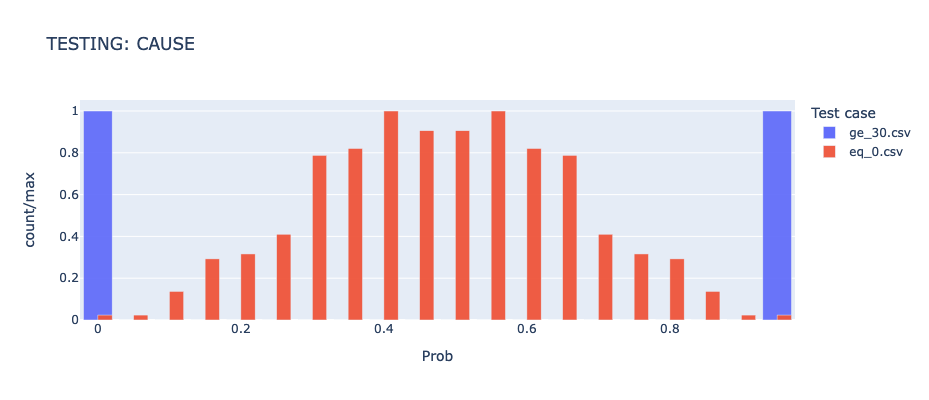

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Using SCHOLARSHIP
Using suod
Loading model from: OUTPUT/SCHOLARSHIP-suod.joblib ...
  Test with data: test_SUICOUNTER_ge_30.csv.zip ...
Computing inliers probabilities ...
Worker 1 sum of ranks: 2.0
Worker 2 sum of ranks: 1.5

Split among workers BPS: [0, 1, 2] [1, 1]
Parallel score prediction...


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Parallel Score Prediction without Approximators Total Time: 0.06068110466003418
  Test with data: test_SUICOUNTER_eq_0.csv.zip ...
Computing inliers probabilities ...
Worker 1 sum of ranks: 2.0
Worker 2 sum of ranks: 1.5

Split among workers BPS: [0, 1, 2] [1, 1]
Parallel score prediction...
Parallel Score Prediction without Approximators Total Time: 0.5828452110290527


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.6s finished


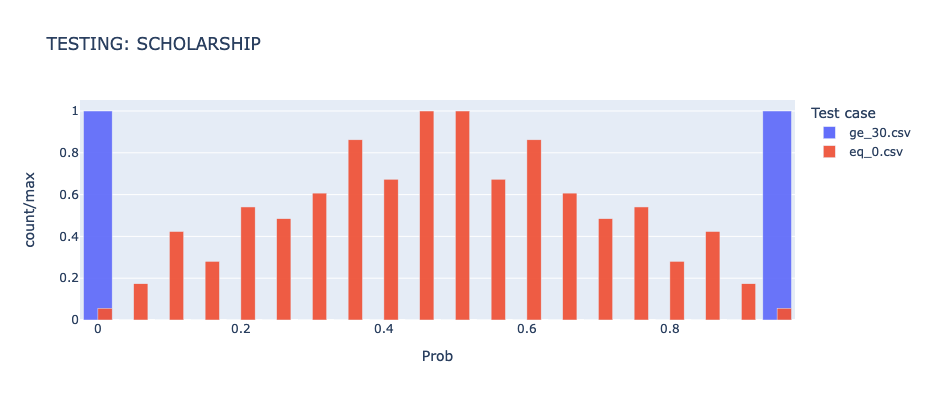

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Using AGE_GROUP
Using suod
Loading model from: OUTPUT/AGE_GROUP-suod.joblib ...
  Test with data: test_SUICOUNTER_ge_30.csv.zip ...
Computing inliers probabilities ...
Worker 1 sum of ranks: 2.0
Worker 2 sum of ranks: 1.5

Split among workers BPS: [0, 1, 2] [1, 1]
Parallel score prediction...


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Parallel Score Prediction without Approximators Total Time: 0.07102108001708984
  Test with data: test_SUICOUNTER_eq_0.csv.zip ...
Computing inliers probabilities ...
Worker 1 sum of ranks: 2.0
Worker 2 sum of ranks: 1.5

Split among workers BPS: [0, 1, 2] [1, 1]
Parallel score prediction...
Parallel Score Prediction without Approximators Total Time: 0.5670008659362793


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.6s finished


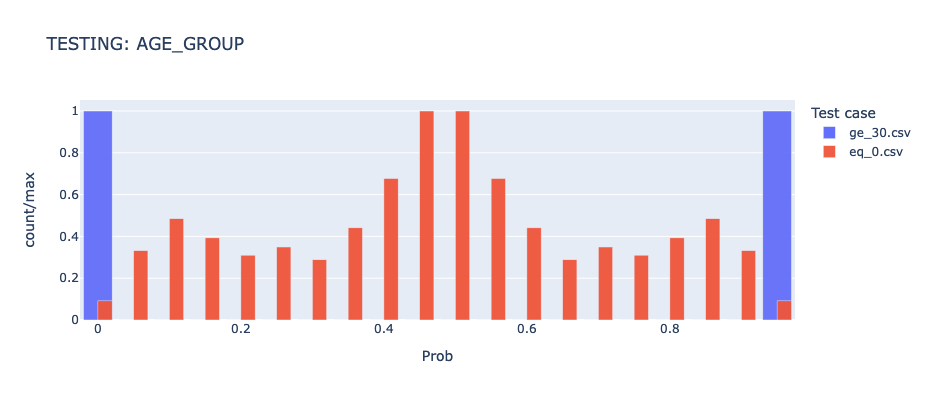

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Using MARITAL_STATUS
Using suod
Loading model from: OUTPUT/MARITAL_STATUS-suod.joblib ...
  Test with data: test_SUICOUNTER_ge_30.csv.zip ...
Computing inliers probabilities ...
Worker 1 sum of ranks: 2.0
Worker 2 sum of ranks: 1.5

Split among workers BPS: [0, 1, 2] [1, 1]
Parallel score prediction...


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   -0.0s remaining:   -0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   -0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Parallel Score Prediction without Approximators Total Time: -0.0012891292572021484
  Test with data: test_SUICOUNTER_eq_0.csv.zip ...
Computing inliers probabilities ...
Worker 1 sum of ranks: 2.0
Worker 2 sum of ranks: 1.5

Split among workers BPS: [0, 1, 2] [1, 1]
Parallel score prediction...
Parallel Score Prediction without Approximators Total Time: 0.5058269500732422


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.5s finished


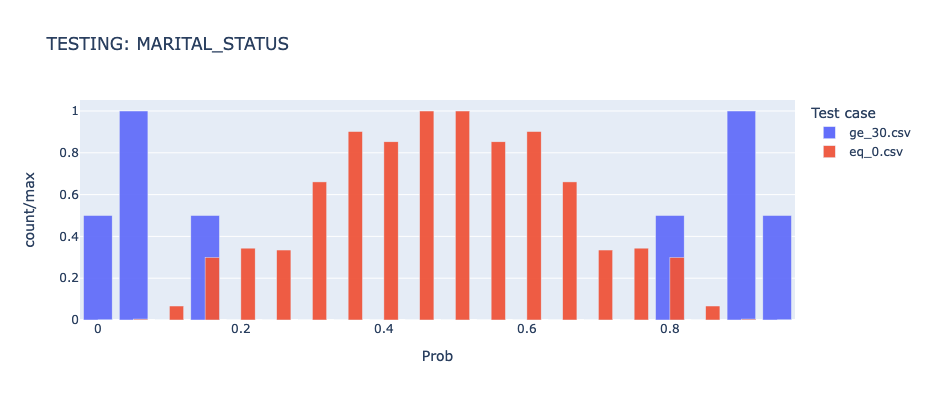

Using VULNERABILITY_FACTOR
Using suod
Loading model from: OUTPUT/VULNERABILITY_FACTOR-suod.joblib ...
  Test with data: test_SUICOUNTER_ge_30.csv.zip ...


In [137]:
MODEL_NAME="suod"
for VAR_NAME in ["CAUSE", "SCHOLARSHIP", "AGE_GROUP", "MARITAL_STATUS", "VULNERABILITY_FACTOR"]:
#for VAR_NAME in ["CAUSE"]:
    test_probs(VAR_NAME, MODEL_NAME)

# Feature Bagging
## Training

In [138]:
CONTAMINATION=0.05
MODEL_NAME="feature_bagging"
for var_name in ["CAUSE", "SCHOLARSHIP", "AGE_GROUP", "MARITAL_STATUS", "VULNERABILITY_FACTOR"]:
#for var_name in ["CAUSE"]:
    print(f"\nTraining with data: {var_name}")
    X_train, _, _, _ = preprocess_data(f"INPUTDATA/NEWCSV/MERGED-2016-2022-Suicidios-Geo-{var_name}.csv", var_name, 
                              MODEL_NAME, expand_rows = True, test_size = 0.001, contamination=CONTAMINATION,
                             nsamples=10000)
    train_model(X_train, var_name, MODEL_NAME, contamination=CONTAMINATION)


Training with data: CAUSE
Reading data from file: INPUTDATA/NEWCSV/MERGED-2016-2022-Suicidios-Geo-CAUSE.csv ...
  Keeping only columns: MUNICIPIO, DPTO, GENDER, CAUSE
  Year is not useful sinde the end user does not use it
Enconding data (using one-hot encoding) ...
dftrain.shape=(10000, 903)
dffull.shape=(115988, 910)
  Saving testing dataframe with SUI_COUNTER==0 ...
  Saving test dataframe with SUI_COUNTER>=30 ...
  Saving test dataframe with SUI_COUNTER>=2 ...
  Saving test dataframe with SUI_COUNTER==2 ...
Saving template dataframe for frontend consulting ...
Replacing rows with SUI_COUNTER = N >= 2 with N rows with SUI_COUNTER = 1 ...
  Initial shape for train dataframe: (10000, 903)
  Appending the new multiplied rows ...
  Final shape for train dataframe: (10701, 903)
  Number of cases == 0:  (9461, 903)
  Number of cases == 1:  (1087, 903)
  Removing rows with SUI_COUNTER >= 2 since rows where expanded ...
dftrain.shape=(10548, 903)
Splitting data into training and test ...
X

## Testing

Using CAUSE
Using feature_bagging
Loading model from: OUTPUT/CAUSE-feature_bagging.joblib ...
  Test with data: test_SUICOUNTER_ge_30.csv.zip ...
Computing inliers probabilities ...
  Test with data: test_SUICOUNTER_eq_0.csv.zip ...
Computing inliers probabilities ...


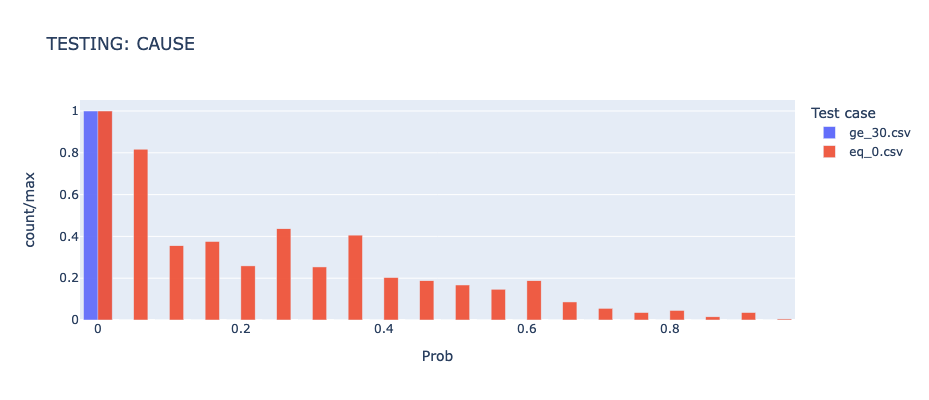

Using SCHOLARSHIP
Using feature_bagging
Loading model from: OUTPUT/SCHOLARSHIP-feature_bagging.joblib ...
  Test with data: test_SUICOUNTER_ge_30.csv.zip ...
Computing inliers probabilities ...
  Test with data: test_SUICOUNTER_eq_0.csv.zip ...
Computing inliers probabilities ...


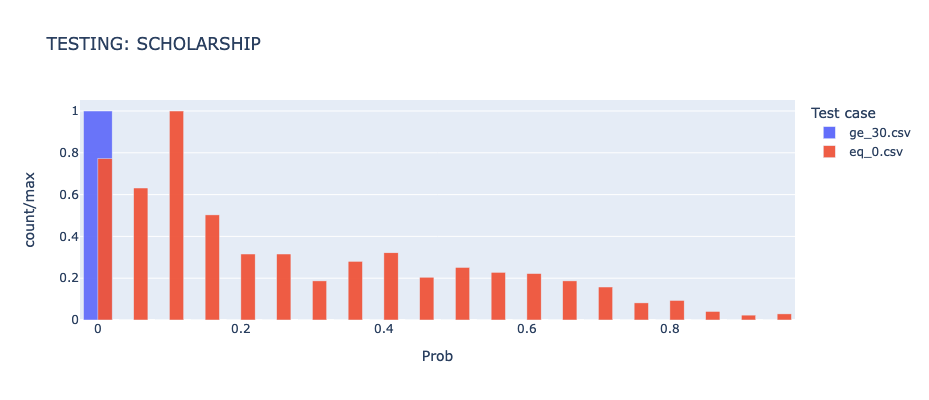

Using AGE_GROUP
Using feature_bagging
Loading model from: OUTPUT/AGE_GROUP-feature_bagging.joblib ...
  Test with data: test_SUICOUNTER_ge_30.csv.zip ...
Computing inliers probabilities ...
  Test with data: test_SUICOUNTER_eq_0.csv.zip ...
Computing inliers probabilities ...


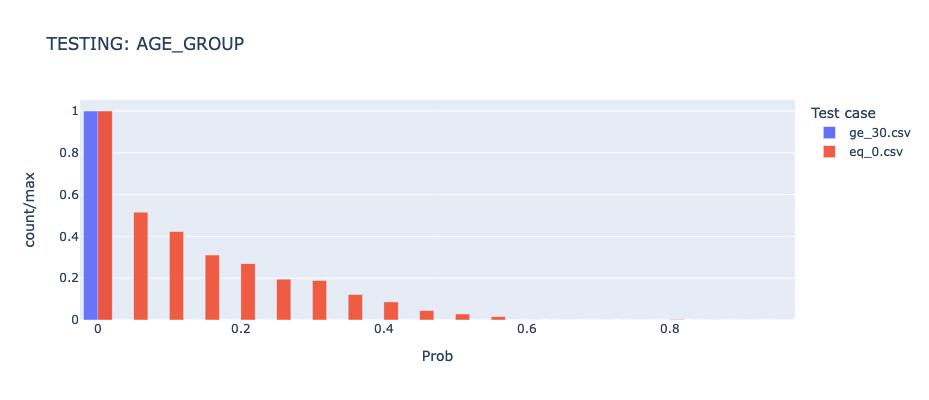

Using MARITAL_STATUS
Using feature_bagging
Loading model from: OUTPUT/MARITAL_STATUS-feature_bagging.joblib ...
  Test with data: test_SUICOUNTER_ge_30.csv.zip ...
Computing inliers probabilities ...
  Test with data: test_SUICOUNTER_eq_0.csv.zip ...
Computing inliers probabilities ...


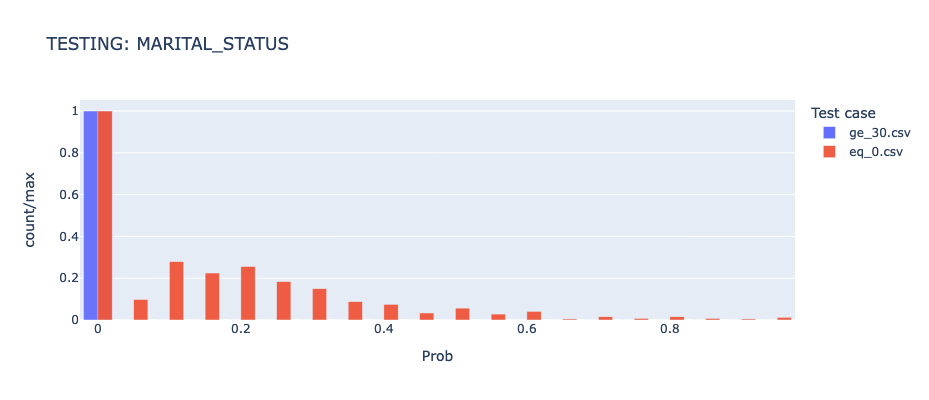

Using VULNERABILITY_FACTOR
Using feature_bagging
Loading model from: OUTPUT/VULNERABILITY_FACTOR-feature_bagging.joblib ...
  Test with data: test_SUICOUNTER_ge_30.csv.zip ...


In [139]:
MODEL_NAME="feature_bagging"
for VAR_NAME in ["CAUSE", "SCHOLARSHIP", "AGE_GROUP", "MARITAL_STATUS", "VULNERABILITY_FACTOR"]:
#for VAR_NAME in ["CAUSE"]:
    test_probs(VAR_NAME, MODEL_NAME)

# brminer: Bagging random miner
- https://github.com/octavioloyola/BRM
- https://link.springer.com/article/10.1007/s00138-018-0957-4

## Training

In [140]:
CONTAMINATION=0.0
MODEL_NAME="brm"
for var_name in ["CAUSE", "SCHOLARSHIP", "AGE_GROUP", "RACIAL_ORIGIN", "MARITAL_STATUS", "VULNERABILITY_FACTOR"]:
#for var_name in ["CAUSE"]:
    print(f"\nTraining with data: {var_name}")
    X_train, X_test, y_train, y_test = preprocess_data(f"INPUTDATA/NEWCSV/MERGED-2016-2022-Suicidios-Geo-{var_name}.csv", 
                                                       var_name, MODEL_NAME, expand_rows = True, test_size = 0.2, 
                                                        contamination=CONTAMINATION, nsamples=8000)
    train_model(X_train, var_name, MODEL_NAME, contamination=CONTAMINATION, y_train=y_train)
    # Compute AUC
    model = load_model(f"OUTPUT/{var_name}-{MODEL_NAME}.joblib")
    y_pred = model.score_samples(X_test)
    auc = roc_auc_score(y_test,  y_pred, multi_class='ovr')
    print(f'Testing AUC: {auc if auc > .5 else 1 - auc}') 
    print("")



Training with data: CAUSE
Reading data from file: INPUTDATA/NEWCSV/MERGED-2016-2022-Suicidios-Geo-CAUSE.csv ...
  Keeping only columns: MUNICIPIO, DPTO, GENDER, CAUSE
  Year is not useful sinde the end user does not use it
Enconding data (using one-hot encoding) ...
dftrain.shape=(8000, 898)
dffull.shape=(115988, 910)
  Saving testing dataframe with SUI_COUNTER==0 ...
  Saving test dataframe with SUI_COUNTER>=30 ...
  Saving test dataframe with SUI_COUNTER>=2 ...
  Saving test dataframe with SUI_COUNTER==2 ...
Saving template dataframe for frontend consulting ...
Replacing rows with SUI_COUNTER = N >= 2 with N rows with SUI_COUNTER = 1 ...
  Initial shape for train dataframe: (8000, 898)
  Appending the new multiplied rows ...
  Final shape for train dataframe: (8634, 898)
  Number of cases == 0:  (7556, 898)
  Number of cases == 1:  (949, 898)
  Removing rows with SUI_COUNTER >= 2 since rows where expanded ...
dftrain.shape=(8505, 898)
Splitting data into training and test ...
X.shap

## Testing

Using CAUSE
Using brm
Loading model from: OUTPUT/CAUSE-brm.joblib ...
  Test with data: test_SUICOUNTER_ge_30.csv.zip ...
Computing inliers probabilities ...
  Test with data: test_SUICOUNTER_eq_0.csv.zip ...
Computing inliers probabilities ...


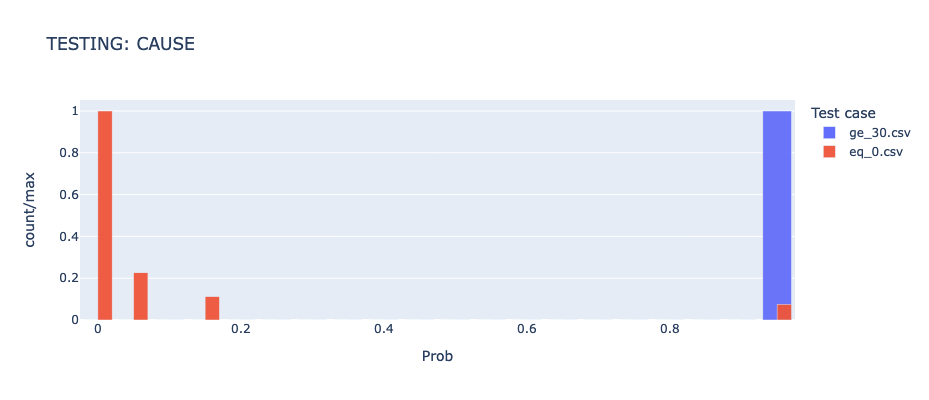

Using SCHOLARSHIP
Using brm
Loading model from: OUTPUT/SCHOLARSHIP-brm.joblib ...
  Test with data: test_SUICOUNTER_ge_30.csv.zip ...
Computing inliers probabilities ...
  Test with data: test_SUICOUNTER_eq_0.csv.zip ...
Computing inliers probabilities ...


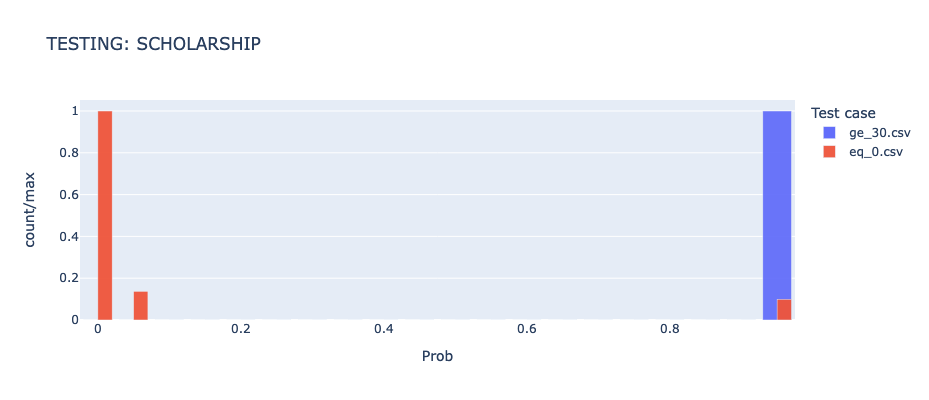

Using AGE_GROUP
Using brm
Loading model from: OUTPUT/AGE_GROUP-brm.joblib ...
  Test with data: test_SUICOUNTER_ge_30.csv.zip ...
Computing inliers probabilities ...
  Test with data: test_SUICOUNTER_eq_0.csv.zip ...
Computing inliers probabilities ...


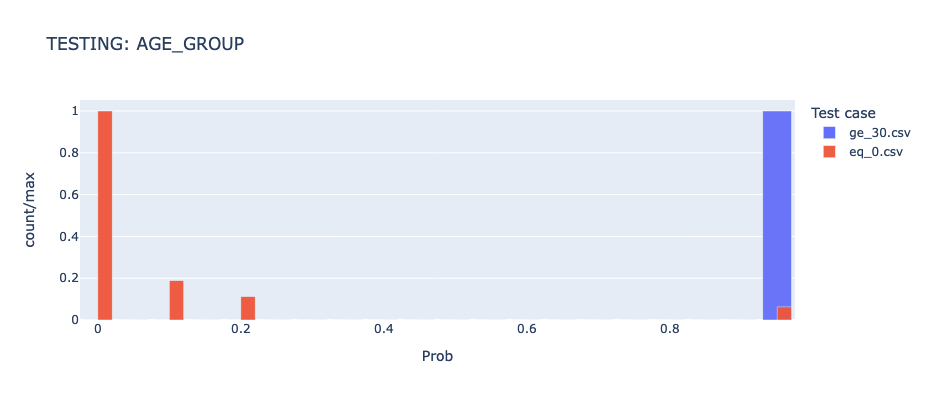

Using RACIAL_ORIGIN
Using brm
Loading model from: OUTPUT/RACIAL_ORIGIN-brm.joblib ...
  Test with data: test_SUICOUNTER_ge_30.csv.zip ...
Computing inliers probabilities ...
  Test with data: test_SUICOUNTER_eq_0.csv.zip ...
Computing inliers probabilities ...


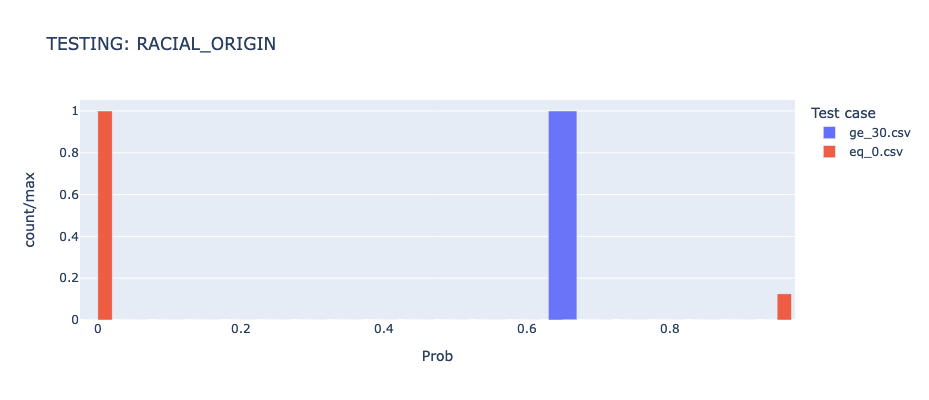

Using MARITAL_STATUS
Using brm
Loading model from: OUTPUT/MARITAL_STATUS-brm.joblib ...
  Test with data: test_SUICOUNTER_ge_30.csv.zip ...
Computing inliers probabilities ...
  Test with data: test_SUICOUNTER_eq_0.csv.zip ...
Computing inliers probabilities ...


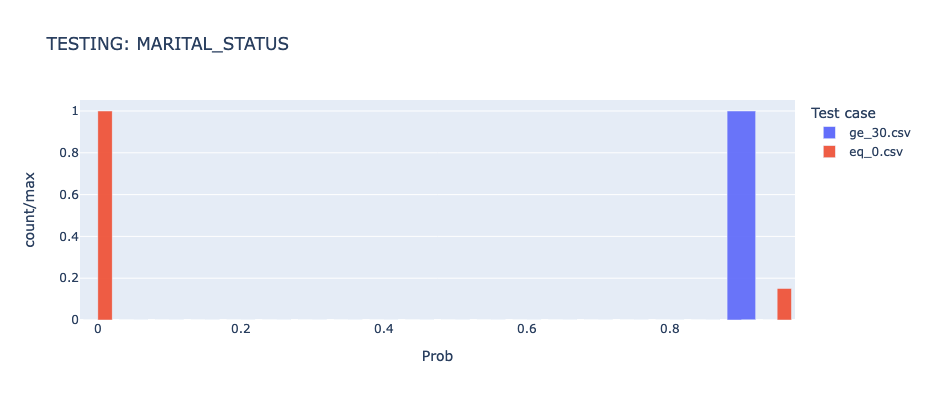

Using VULNERABILITY_FACTOR
Using brm
Loading model from: OUTPUT/VULNERABILITY_FACTOR-brm.joblib ...
  Test with data: test_SUICOUNTER_ge_30.csv.zip ...


In [141]:
# "AGE_GROUP" not included since data is incorrect
MODEL_NAME="brm"
for VAR_NAME in ["CAUSE", "SCHOLARSHIP", "AGE_GROUP", "RACIAL_ORIGIN", "MARITAL_STATUS", "VULNERABILITY_FACTOR"]:
#for VAR_NAME in ["VULNERABILITY_FACTOR"]:
    test_probs(VAR_NAME, MODEL_NAME)    

## Computing probabilities

In [110]:
VAR_NAME="CAUSE"
MODEL_NAME="brm"
model = load_model(f"OUTPUT/{VAR_NAME}-{MODEL_NAME}.joblib")
print(compute_prob("BOGOTA", "BOGOTA", "MASCULINO", VAR_NAME, "Desamor", model, MODEL_NAME, verbose=False))
print(compute_prob("BOGOTA", "BOGOTA", "FEMENINO", VAR_NAME, "Desamor", model, MODEL_NAME, verbose=False))
print(compute_prob("ANTIOQUIA", "MEDELLIN", "MASCULINO", VAR_NAME, "Bullying", model, MODEL_NAME))
print(compute_prob("CAUCA", "SUAREZ", "MASCULINO", VAR_NAME, "Acceso a armas de fuego", model, MODEL_NAME, verbose=False))

# No suicide
print("No suicide")
print(compute_prob("CORDOBA", "TUCHIN", "MASCULINO", VAR_NAME, "Sin información Razon del suicidio", model, MODEL_NAME, verbose=True))
# Many (>30) suicide
print(">30 suicide")
print(compute_prob("BOGOTA", "BOGOTA", "MASCULINO", VAR_NAME, "Enfermedad física o mental", model, MODEL_NAME, verbose=False))
# 2 suicides
print("2 suicides")
print(compute_prob("BOLIVAR", "ARJONA", "MASCULINO", VAR_NAME, "Sin información Razon del suicidio", model, MODEL_NAME, verbose=False))


Loading model from: OUTPUT/CAUSE-brm.joblib ...
0.04876170629946909
0.04876170629946909
0.04876170629946909
0.5243933771031607
No suicide
decision_scores=array([0.72138875])
prob=array([0.04876171])
0.04876170629946909
>30 suicide
1.0
2 suicides
1.0


# XGBOD: Improving Supervised Outlier Detection with Unsupervised Representation Learning (SLOW). 

A semi-supervised outlier detection framework.

## Training

In [145]:
# "AGE_GROUP" not included since data is incorrect
CONTAMINATION=0.0
MODEL_NAME="xgbod"
for var_name in ["CAUSE", "SCHOLARSHIP", "AGE_GROUP", "MARITAL_STATUS", "VULNERABILITY_FACTOR"]:
#for var_name in ["CAUSE"]:
    print(f"\nTraining with data: {var_name}")
    X_train, X_test, y_train, y_test = preprocess_data(f"INPUTDATA/NEWCSV/MERGED-2016-2022-Suicidios-Geo-{var_name}.csv", 
                                                       var_name, MODEL_NAME, expand_rows = True, test_size = 0.2, 
                                                       contamination=CONTAMINATION, nsamples=10000)
    train_model(X_train, var_name, MODEL_NAME, contamination=CONTAMINATION, y_train=y_train)


Training with data: CAUSE
Reading data from file: INPUTDATA/NEWCSV/MERGED-2016-2022-Suicidios-Geo-CAUSE.csv ...
  Keeping only columns: MUNICIPIO, DPTO, GENDER, CAUSE
  Year is not useful sinde the end user does not use it
Enconding data (using one-hot encoding) ...
dftrain.shape=(10000, 903)
dffull.shape=(115988, 910)
  Saving testing dataframe with SUI_COUNTER==0 ...
  Saving test dataframe with SUI_COUNTER>=30 ...
  Saving test dataframe with SUI_COUNTER>=2 ...
  Saving test dataframe with SUI_COUNTER==2 ...
Saving template dataframe for frontend consulting ...
Replacing rows with SUI_COUNTER = N >= 2 with N rows with SUI_COUNTER = 1 ...
  Initial shape for train dataframe: (10000, 903)
  Appending the new multiplied rows ...
  Final shape for train dataframe: (10701, 903)
  Number of cases == 0:  (9461, 903)
  Number of cases == 1:  (1087, 903)
  Removing rows with SUI_COUNTER >= 2 since rows where expanded ...
dftrain.shape=(10548, 903)
Splitting data into training and test ...
X

## Testing 

Using CAUSE
Using xgbod
Loading model from: OUTPUT/CAUSE-xgbod.joblib ...
  Test with data: test_SUICOUNTER_ge_30.csv.zip ...
Computing inliers probabilities ...
  Test with data: test_SUICOUNTER_eq_0.csv.zip ...
Computing inliers probabilities ...


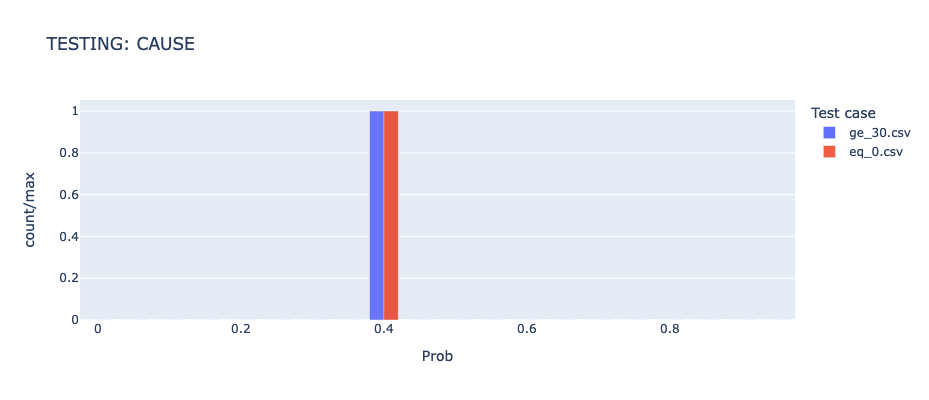

Using SCHOLARSHIP
Using xgbod
Loading model from: OUTPUT/SCHOLARSHIP-xgbod.joblib ...
  Test with data: test_SUICOUNTER_ge_30.csv.zip ...
Computing inliers probabilities ...
  Test with data: test_SUICOUNTER_eq_0.csv.zip ...
Computing inliers probabilities ...


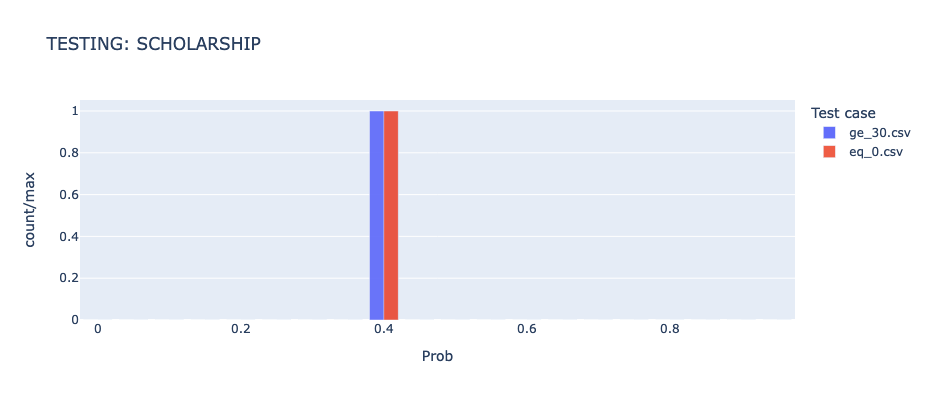

Using AGE_GROUP
Using xgbod
Loading model from: OUTPUT/AGE_GROUP-xgbod.joblib ...
  Test with data: test_SUICOUNTER_ge_30.csv.zip ...
Computing inliers probabilities ...
  Test with data: test_SUICOUNTER_eq_0.csv.zip ...
Computing inliers probabilities ...


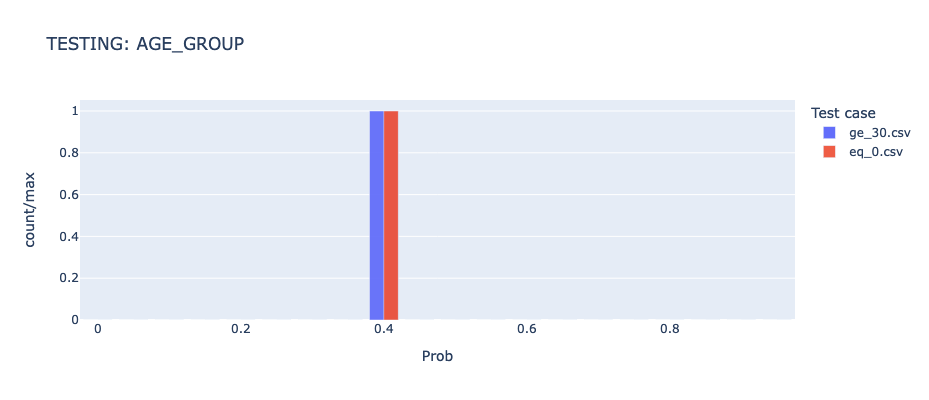

Using MARITAL_STATUS
Using xgbod
Loading model from: OUTPUT/MARITAL_STATUS-xgbod.joblib ...
  Test with data: test_SUICOUNTER_ge_30.csv.zip ...
Computing inliers probabilities ...
  Test with data: test_SUICOUNTER_eq_0.csv.zip ...
Computing inliers probabilities ...


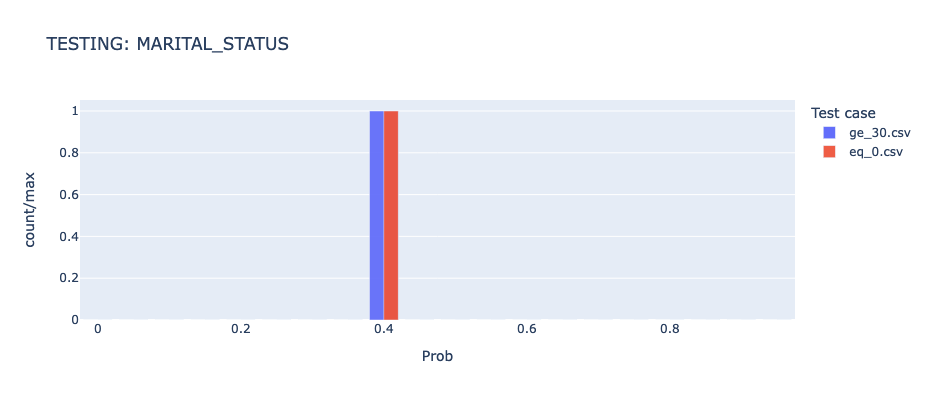

Using VULNERABILITY_FACTOR
Using xgbod
Loading model from: OUTPUT/VULNERABILITY_FACTOR-xgbod.joblib ...
  Test with data: test_SUICOUNTER_ge_30.csv.zip ...


In [147]:
MODEL_NAME="xgbod"
for VAR_NAME in ["CAUSE", "SCHOLARSHIP", "AGE_GROUP", "MARITAL_STATUS", "VULNERABILITY_FACTOR"]:
#for VAR_NAME in ["CAUSE"]:
    test_probs(VAR_NAME, MODEL_NAME)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=70a6331b-3e37-4c4d-8041-2d29d0ba96c1' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>